#Errors in serial dilution: how does dispensing technology matter?

####[Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center

In a recent paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a large discrepancy was observed in IC50 assay values in which either a LabCyte Echo acoustic dispensing unit or a Tecan Genesis liquid handling workstation were used in performing the assays.  [Should we also reference nature blogs and in the pipeline posts here?]

#<span style="color:blue">insert quote here</span>

This discrepancy may be due to any number of factors, but one of the main features of the Echo is its direct dispensing technology that allows a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

#<span style="color:blue">insert figure here</span>

###Here we experiment with some simple python models to see what could be the source of these discrepencies.

### 0. Define assay setup

In [53]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d
%pylab inline
sns.set(style='white')
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Our general assay setup is of 8 points of 100 uL each in our dilution series (including the original concentration), starting with an initial concentration of 10 mM in DMSO stock. Each point will be diluted be a factor 2 dilution of the previous step.

#<span style="color:blue">insert figure here</span>

Define number of points in dilution series (including original stock):

In [54]:
ndilutions = 8

Define original volume as 100 µL:

In [55]:
V0 = 100e-6

Define stock concentration as 10 mM:

In [56]:
C0 = 10e-3

Define specific parameters of the dilution series (transferring 50 µL into 50 µL buffer at each step):

In [57]:
Vtransfer = 50e-6
Vbuffer = 50e-6

Define dilution series function:

In [58]:
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

In [59]:
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

In [60]:
print "Thus we now have an %s part dilution series from %s M to %s M." % (ndilutions, C0, ideal_concentrations[-1])

Thus we now have an 8 part dilution series from 0.01 M to 7.8125e-05 M.


Let's plot it!

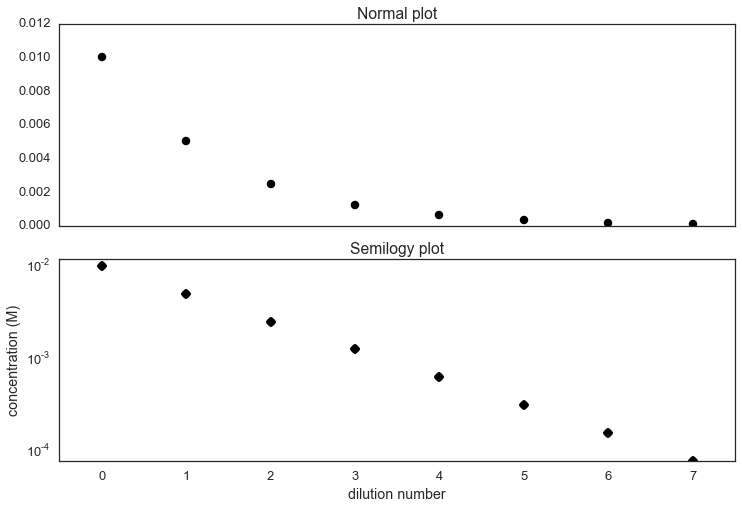

In [61]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(range(ndilutions), ideal_concentrations, lw=4)
ax1.set_title("Normal plot")
ax2.semilogy(range(ndilutions), ideal_concentrations,'ko')
ax2.set_title("Semilogy plot")
plt.xlabel('dilution number')
plt.ylabel('concentration (M)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
f.tight_layout()

First we'll model how a human or a liquid-handling robot does a serial dilution, then we'll model how direct dispense technology does for the same dilution series.

### 1. Dilution and dispensing by a liquid-handling robot.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). We'll ignore other contributions to error, such as compound stickiness, insolubility, etc.

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published specs for imprecision for the Genesis are available:

[imprecision data for Tecan Genesis](http://www.frankshospitalworkshop.com/equipment/documents/automated_analyzer/user_manuals/Tecan%20Genesis%20RMP%20-%20User%20manual.pdf)

Specs, however, for inaccuracy were not available (the Genesis has actually not been in production for some time now, note our sorta sketchy link above, too), so we'll use similar inaccuracy data for the Beckman NX/FX span-8 instead:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)


#<span style="color:blue">insert chart from link here</span>

Define pipetting error function for the genesis:

In [62]:
def tecan_genesis_pipetting_model(volume):
    # Imprecision from Tecan Genesis manual.
    # Inaccuracy estimated from Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [10e-6,100e-6], # Volume Range
        [0.03,0.005]) # published imprecision for Tecan Genesis
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # Volume Range
        [0.05, 0.03, 0.03]) # published inaccuracy for Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [63]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [0,0],
        [0.03,0.005]) 
    inaccuracy_function = interp1d(
        [0, 0, 0],
        [0.05, 0.03, 0.03]) 
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

#<span style="color:blue">Add better description of what is changing.</span>

Now we'll apply this error to our dilution series:

In [64]:
# define ROBOT_dilution_series function
def ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
            actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [65]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

Let's plot it!

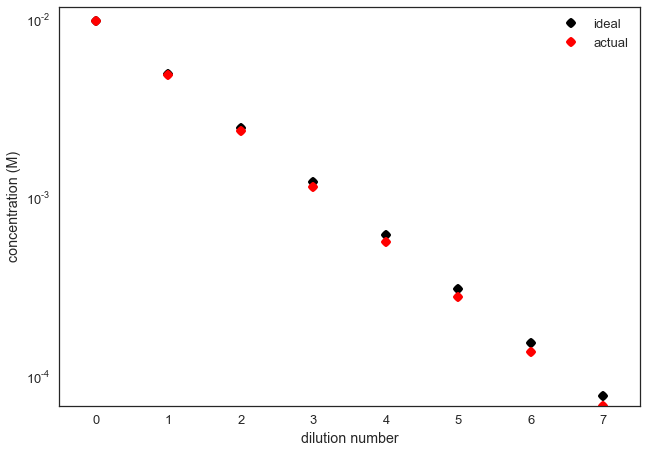

In [66]:
plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, C0 * 1.2]);

What if we plot the relative errors in concentration, volume, and total quantity of compound per well?

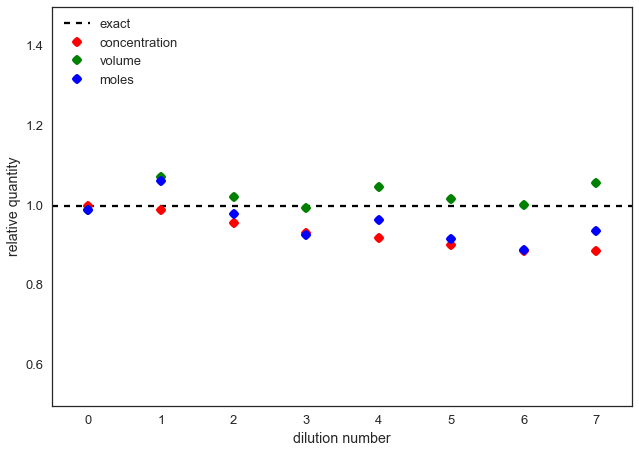

In [67]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--')
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo')
plt.legend(['exact', 'concentration', 'volume', 'moles'], loc='upper left')
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number')

This is kind of all over the place, with no obvious trend, but what if we repeat the experiment many times? Then we can estimate the coefficient of variation (CV) for each dilution number.

Let's repeat the experiment 5000 times:

In [68]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [69]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

And let's plot it!

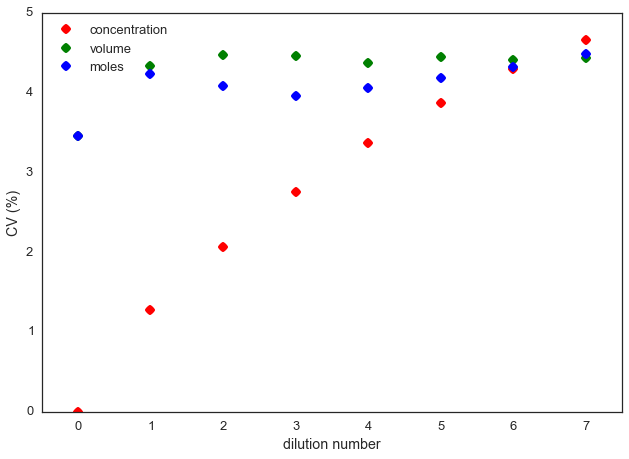

In [78]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'moles'], loc='upper left')

So these are the errors we're getting just by looking at inaccuracy and imprecision. Notice how the concentration error creeps up to almost 20% in the last sample?

But is there a bias at all as a result of this?

Let's look at the mean of all these values for this 5000 replicate test.

[-0.5, 7.5, -100, 100]

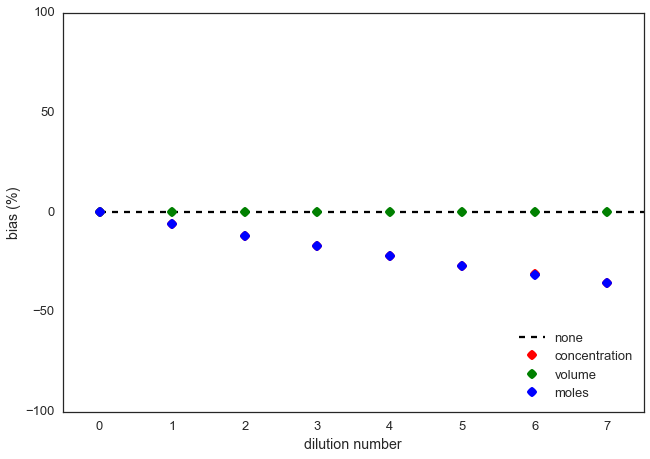

In [79]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'ro', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100])

Despite some creep in the eror, it doesn't seem like there's a tremendous bias.

###But wait!

###We still have one more source of error to add!

In an interesting paper by Dong et al, [The use of a dual dye photometric calibration method to identify possible sample dilution from an automated multichannel liquid-handling system. J. Lab. Autom. 11(2): 2006](http://dx.doi.org/10.1016/j.jala.2006.02.005), they reveal that the system liquid on the inside of the steel fixed tips of the Tecan Genesis can result in significant dilution errors.

In [72]:
# define dilution_function
volume = numpy.array([20, 200]) * 1e-6 
dilution_effect = numpy.array([-0.0630, -0.0496])

dilution_function = interp1d(volume, dilution_effect)
    

In [73]:
# define DILUTE_ROBOT_dilution_series function
def DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilute dilution series 
    # Observe only change is in actual_concentrations[n].
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
             actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)\
             * (1+dilution_function(Vtransfer))
        actual_volumes[n] += Vtransfer_actual 
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    #Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]



And repeat!

In [74]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Let's see what our CV's look like now!

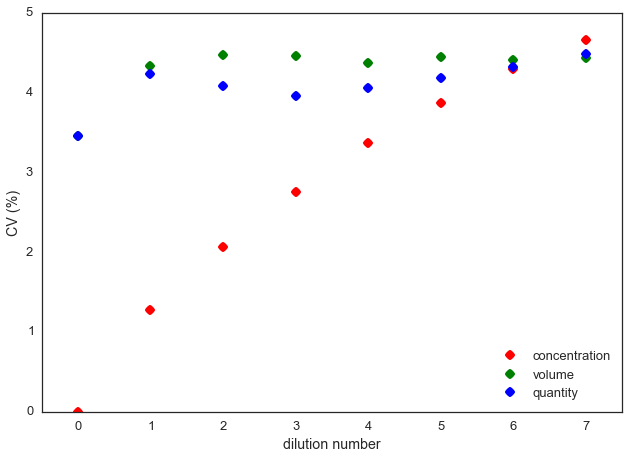

In [80]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
plt.plot(dilutions, concentrations_cv*100, 'ro', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions -0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='lower right')

Now, let's check the bias again.

[-0.5, 7.5, -100, 100]

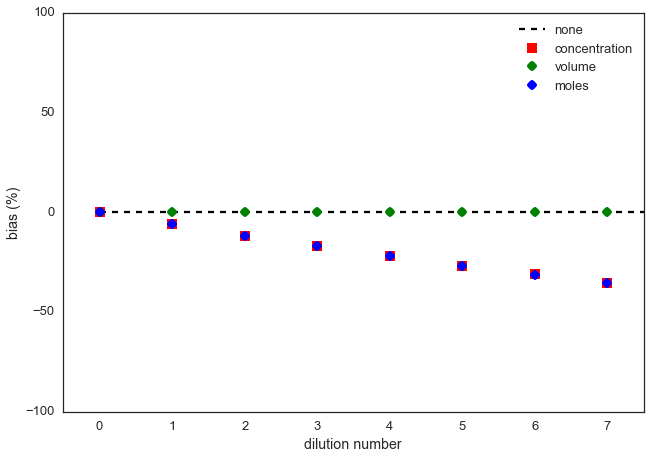

In [83]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs',\
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none', 'concentration', 'volume', 'moles'], loc='upper right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100])

Definitely some bias in there now. Even though the volume error is evenly distributed, the concentration error is constantly decreasing, which means the actually quantity (moles) used is also decreasing.

### 2. Dispensing by direct dispensing with the LabCyte Echo.

What about the LabCyte Echo experiments? According to LabCyte, the Echo has an inaccuracy of 10% and a precision of 8% over the entire dispense range of 2.5 nL to 10 uL. Let's model how it dispenses directly into the assay plate with an 9-point dilution series spanning 2.5 nL to 120 nL from 10 mM stock solution.

#<span style="color:blue">insert figure here</span>

Define stock concentration as 10 mM:

In [123]:
C0 = 10e-3

Define assay volume as 12 uL (note that ideal assay volume here is different than the serial dilution setup):

In [124]:
assay_volume = 12e-6

Define 9-point titration (multiples of 2.5 nL):

In [125]:
dispense_volumes = 2.5e-9 * numpy.array([6, 12, 18, 24, 30, 36, 42, 48])

Define the concentrations in this titration:

In [126]:
concentrations = (C0*dispense_volumes/assay_volume)

To make sure our DMSO concentration does not vary as we vary our compound concentration, we'll always backfill up to 120 nL total DMSO:

In [127]:
backfill_volume = 120e-9

Define the mix volume as assay_volume - backfill_volume, e.g. 12 uL assay volume minus 120 uL:

In [128]:
mix_volume = assay_volume - backfill_volume

In [129]:
#ndilutions, volumes, backfill, min


Published specs for the LabCyte Echo are available:

[inaccuracy/imprecision data for LabCyte Echo](http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf)

In [130]:
# define echo_assay_dispense function
def echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes):
    inaccuracy = 0.10
    imprecision = 0.08

    ndilutions = len(dispense_volumes)
    echo_volume = numpy.zeros([ndilutions], numpy.float64)
    echo_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    
    for i in range(ndilutions):
        compound_volume_intended = dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        echo_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        echo_concentration[i] = C0 * compound_volume_dispensed / echo_volume[i]

    return [echo_volume, echo_concentration]

In [131]:
[echo_volumes, echo_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)

Let's plot this:

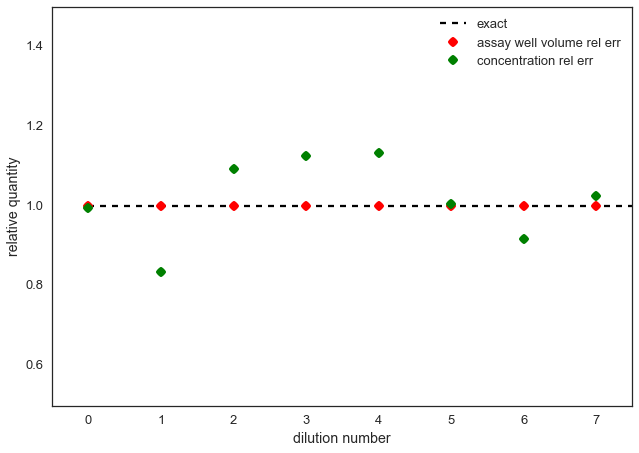

In [132]:
plt.plot([0,ndilutions], [1, 1], 'k--', range(ndilutions), echo_volumes / assay_volume,'ro',\
         range(ndilutions), echo_concentrations / concentrations, 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='upper right')
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number')

And repeat!

In [136]:
nreplicates = 10000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

ndilutions = len(dispense_volumes)
volume_array = numpy.ones([ndilutions]) * assay_volume

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / volume_array).std(0)
concentrations_cv = (actual_concentrations_n / concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (volume_array * concentrations)).std(0)

Let's plot CV's!

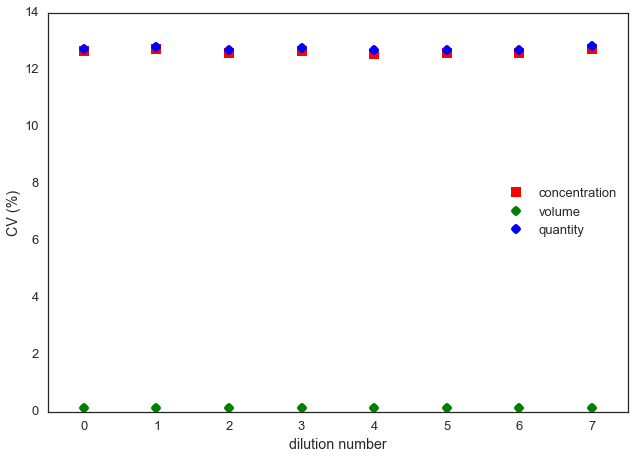

In [138]:
#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

plt.plot(dilutions, concentrations_cv*100, 'rs', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5,ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='center right')

### 3. How do IC50 estimates between these compare?

### 4. At the Chodera Lab we use the D300 for our direct dispensing needs!